# Assignment 7
1. Import the data located at this link. It has information on people infected with dengue at the district level for 2015 to 2021.
2. Generate ubigeo for Departments and Provinces taking the first two and four numbers. Hint: Use this code.
3. Use geopandas to plot the number of cases in 2021 by the district using a continuous legend. Do not forget to indicate the color of NA values. Use      this shapefile.
4. Use geopandas to plot the number of cases in 2021 by the province using a continuous legend. Do not forget to indicate the color of NA values. Use      this shapefile. For this task, you will have to aggregate shapefiles at the province level.
5. Use geopandas to plot the number of cases by the department for all the years using subplots. Every subplot for each year. Do not forget to indicate    the color of NA values. Use this shapefile. For this task, you will have to aggregate shapefiles at the department level.
6. Use geopandas to plot the number of cases by the department for all 2021 quarters using subplots. Every subplot for each quarter. Use a categorical     legend with 5 bins. Do not forget to indicate the color of NA values. Use this shapefile. For this task, you will have to aggregate shapefiles at       the department level. Hint: Use Semana variable to group by quarters.a

Group 3:
Claudia Córdova Yamauchi, Mauricio Flores Jiménez, Reynaldo Padilla Milla, Fátima Trujillo Quiñe, Vania Aspilcueta Serey

In [ ]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }a
</style>
"""))

# Cargamos las librerías necesarias

In [2]:
#Required Libraries
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import chardet

import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, LineString
import folium
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap

#1. Importar la base de datos

Cargamos la base de datos, nos aseguramos de que la configuranción es la recomendada y hacemos una inspección rápida.

In [4]:
charenc = chardet.detect(open('../../_data/data_dengue_peru.csv', 'rb').read())['encoding']
print(charenc)
print('\n')
dengue = pd.read_csv( '../../_data/data_dengue_peru.csv', encoding = charenc)
print('Dimensiones del df:', dengue.shape)
print('\n')
print(dengue.dtypes)

UTF-8-SIG


Dimensiones del df: (172144, 8)


Año                 int64
Semana              int64
Eventos o daños    object
Departamento       object
Distrito           object
Provincia          object
Ubigeo              int64
Casos              object
dtype: object


C:\Users\Mauricio\AppData\Local\Temp\ipykernel_5480\1002911966.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dengue = pd.read_csv( '../../_data/data_dengue_peru.csv', encoding = charenc)


# 1. Import data from data_dengue.csv
dengue_data = pd.read_csv('../../_data/data_dengue_peru.csv', low_memory=False, converters={'Casos': lambda x: float(x.replace(',', '')) if x != '' else np.nan})

#Ubigeo is int64, I better change it to String
dengue_data['Ubigeo'] = dengue_data['Ubigeo'].astype(str)


In [6]:
dengue.head(5)

,Año,Semana,Eventos o daños,Departamento,Distrito,Provincia,Ubigeo,Casos
0,2020,43,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,2.0
1,2021,41,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN
2,2021,42,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN
3,2020,1,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,0.0
4,2020,53,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,2.0


In [8]:
cols_1 = ['Eventos o daños', 'Departamento', 'Distrito', 'Provincia']
dengue[cols_1] = dengue[cols_1].astype('string')
print(dengue.dtypes)
print('\n')
#Por el tipo de data, el identificador se repetirá varias veces (hay datos por año y semana). Es normal que no sea único.
print(dengue['Ubigeo'].is_unique)
print('\n')
#Verificamos si la columna Casos tiene valores con coma (p. ej., 1,000 en vez de 1000).
#Si True, al menos uno tiene coma.
ValorConComa = dengue['Casos'].str.contains(',').any()
print(ValorConComa)

Año                         int64
Semana                      int64
Eventos o daños    string[python]
Departamento       string[python]
Distrito           string[python]
Provincia          string[python]
Ubigeo                      int64
Casos                      object
dtype: object


False


True


In [10]:
#Pasamos la columna 'Ubigeo' (ID del distrito) a string. Si está como integer o Int64, se eliminan los 0 a la izquierda.
#El ID debe tener 6 dígitos. Si solo hay 5, le añadimos un 0 al inicio. 
dengue['Ubigeo'] = dengue['Ubigeo'].apply(lambda row: str(row).zfill(6))
dengue.head(5)

,Año,Semana,Eventos o daños,Departamento,Distrito,Provincia,Ubigeo,Casos
0,2020,43,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,2.0
1,2021,41,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN
2,2021,42,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN
3,2020,1,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,0.0
4,2020,53,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,2.0


In [12]:
# Recodificamos los valores de la columna 'Casos'.
# Primero, aplicamos una función lambda a cada valor (fila) de la columna 'Casos'.
# La función convierte cada valor a string y elimina la coma (si la tiene), pero solo si el valor no es NaN.
# Si el valor es NaN (pd.notna(row) es False), lo dejamos sin cambios.
# Después, convertimos los valores a 'float' para que Pandas permita la conversión a 'Int64'.
# Finalmente, convertimos los valores a 'Int64', lo cual es adecuado para un conteo de casos.
# Usamos 'Int64' en lugar de 'int' para permitir que los valores NaN se mantengan sin alterarse.
dengue['Casos'] = dengue['Casos'].apply(lambda row: str(row).replace(',', '') if pd.notna(row) else row).astype(float).astype('Int64')
dengue.head(5)

,Año,Semana,Eventos o daños,Departamento,Distrito,Provincia,Ubigeo,Casos
0,2020,43,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,2
1,2021,41,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,<NA>
2,2021,42,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,<NA>
3,2020,1,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,0
4,2020,53,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,2


#2. Creamos Ubigeo para los departamentos y las provincias

In [14]:
#Creamos la columna 'Ubigeo_Departamento' extrayendo los dos primeros caracteres de 'Ubigeo'.
dengue['Ubigeo_Departamento'] = dengue['Ubigeo'].str[0:2]
#Creamos la columna 'Ubigeo_Provincia' extrayendo los cuatro primeros caracteres de 'Ubigeo'.
dengue['Ubigeo_Provincia'] = dengue['Ubigeo'].str[0:4]
dengue.head(5)

,Año,Semana,Eventos o daños,Departamento,Distrito,Provincia,Ubigeo,Casos,Ubigeo_Departamento,Ubigeo_Provincia
0,2020,43,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,2,08,0809
1,2021,41,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,<NA>,18,1801
2,2021,42,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,<NA>,18,1801
3,2020,1,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,0,08,0809
4,2020,53,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,2,08,0809


#3. Preparamos los datos para realizar la primera figura

In [16]:
#Cargamos los datos del shapefile para obtener los polígonos (mapas) de los distritos
distritos_shp = gpd.read_file('../../_data/LIMITE_DISTRITAL_2020_INEI/INEI_LIMITE_DISTRITAL.shp')
#Verificamos si el archivo tiene información sobre la proyección. Debe ser EPSG: 4326 (para WGS-84).
print(distritos_shp.crs), print('\n')
print(distritos_shp.shape, '\n')
distritos_shp.head(5)

EPSG:4326


(1874, 16) 



,CCDD,NOMBDEP,CCPP,NOMBPROV,CCDI,NOMBDIST,CAPITAL,UBIGEO,IDPROV,CODIGO,CNT_CCPP,DESCRIPCIO,DESCARGAR,WHATSAPP,CONTACTO,geometry
0,06,CAJAMARCA,05,CONTUMAZA,04,GUZMANGO,GUZMANGO,060504,0605,060504,50,GUZMANGO,www.geogpsperu.com,931381206,juan.suyo@geogpsperu.com,"POLYGON ((-78.91578 -7.32085, -78.91370 -7.322..."
1,06,CAJAMARCA,11,SAN MIGUEL,05,EL PRADO,EL PRADO,061105,0611,061105,15,EL PRADO,www.geogpsperu.com,931381206,juan.suyo@geogpsperu.com,"POLYGON ((-79.01679 -6.96945, -79.01581 -6.969..."
2,06,CAJAMARCA,11,SAN MIGUEL,09,NIEPOS,NIEPOS,061109,0611,061109,41,NIEPOS,www.geogpsperu.com,931381206,juan.suyo@geogpsperu.com,"POLYGON ((-79.21691 -6.85171, -79.21576 -6.851..."
3,06,CAJAMARCA,11,SAN MIGUEL,10,SAN GREGORIO,SAN GREGORIO,061110,0611,061110,48,SAN GREGORIO,www.geogpsperu.com,931381206,juan.suyo@geogpsperu.com,"POLYGON ((-79.08233 -7.00544, -79.08041 -7.005..."
4,06,CAJAMARCA,12,SAN PABLO,03,SAN LUIS,SAN LUIS GRANDE,061203,0612,061203,9,SAN LUIS,www.geogpsperu.com,931381206,juan.suyo@geogpsperu.com,"POLYGON ((-78.87623 -7.09747, -78.87471 -7.098..."


In [18]:
print('¿Los valores de UBIGEO son únicos?', distritos_shp['UBIGEO'].is_unique, '. Hay:', distritos_shp['UBIGEO'].unique().size)
#Al 2021, el Perú tenía 1874 distritos.
print(distritos_shp['UBIGEO'].dtype)

¿Los valores de UBIGEO son únicos? True . Hay: 1874
object


In [102]:
mapas = distritos_shp[['CCDD', 'IDPROV', 'UBIGEO', 'geometry']].copy()
mapas.rename(columns = {'CCDD': 'Ubigeo_Departamento', 'IDPROV': 'Ubigeo_Provincia', 'UBIGEO': 'Ubigeo'}, inplace = True)
mapas[['Ubigeo_Departamento', 'Ubigeo_Provincia', 'Ubigeo']] = mapas[['Ubigeo_Departamento', 'Ubigeo_Provincia', 'Ubigeo']].astype(str)
print(f'Deben haber 1874 filas (distritos al 2021):', mapas.shape)
mapas.head(5)

Deben haber 1874 filas (distritos al 2021): (1874, 4)


,Ubigeo_Departamento,Ubigeo_Provincia,Ubigeo,geometry
0,06,0605,060504,"POLYGON ((-78.91578 -7.32085, -78.91370 -7.322..."
1,06,0611,061105,"POLYGON ((-79.01679 -6.96945, -79.01581 -6.969..."
2,06,0611,061109,"POLYGON ((-79.21691 -6.85171, -79.21576 -6.851..."
3,06,0611,061110,"POLYGON ((-79.08233 -7.00544, -79.08041 -7.005..."
4,06,0612,061203,"POLYGON ((-78.87623 -7.09747, -78.87471 -7.098..."


In [122]:
# Filtrar las filas donde 'Año' es 2021
dengue_2021 = dengue[dengue['Año'] == 2021]

# Reordenar las columnas según lo solicitado
dengue_2021 = dengue_2021[['Ubigeo_Departamento', 'Ubigeo_Provincia', 'Ubigeo', 'Departamento', 'Provincia', 'Distrito', 'Año', 'Semana', 'Casos']]

dengue_2021.head(5)

,Ubigeo_Departamento,Ubigeo_Provincia,Ubigeo,Departamento,Provincia,Distrito,Año,Semana,Casos
1,18,1801,180101,MOQUEGUA,MARISCAL NIETO,MOQUEGUA,2021,41,<NA>
2,18,1801,180101,MOQUEGUA,MARISCAL NIETO,MOQUEGUA,2021,42,<NA>
6,15,1501,150112,LIMA,LIMA,INDEPENDENCIA,2021,41,<NA>
7,15,1501,150143,LIMA,LIMA,VILLA MARIA DEL TRIUNFO,2021,41,<NA>
8,15,1501,150103,LIMA,LIMA,ATE,2021,41,<NA>


In [104]:
# Definimos una función para sumar los casos.
# Si más del 65% de los valores en el grupo son NA, la suma será NA.
# Si menos del 65% son NA, sumamos los casos ignorando los valores NA.
def sumar_casos(total):
    if total.isna().mean() >= 0.65:
        return pd.NA  # Si más del 65% son NA, devolvemos NA
    else:
        return total.sum()  # Si no, sumamos los valores no NA

# Generamos el nuevo df 'df_2021', agrupando por 'Ubigeo' y aplicando la función sumar_casos
df_2021 = dengue_2021.groupby('Ubigeo', as_index=False).agg(
          Casos_distrital_2021=('Casos', sumar_casos))

# Hacemos un merge para agregar la columna 'Ubigeo' y 'geometry' desde el df 'mapas'
df_2021 = pd.merge(mapas[['Ubigeo_Departamento', 'Ubigeo_Provincia', 'Ubigeo', 'geometry']], df_2021, on='Ubigeo', how='left')

# Hacemos un merge para agregar información desde el df dengue. Debemos indicar drop_duplicates() para no repetir cada fila
df_2021 = pd.merge(df_2021, 
                   dengue_2021[['Departamento', 'Provincia', 'Distrito', 'Ubigeo']].drop_duplicates(), 
                   on = 'Ubigeo', 
                   how = 'left')

# Añadimos una columna Año con valor 2021
df_2021['Año'] = '2021'

# Reordenamos las columnas
df_2021 = df_2021[['Año', 'Ubigeo_Departamento', 'Ubigeo_Provincia', 'Ubigeo', 'Departamento', 'Provincia', 'Distrito', 'Casos_distrital_2021', 'geometry']]

#df_2021.head(20)
print(df_2021.dtypes)
print('\n', f'El n de filas debería ser 1874:', df_2021.shape)

Año                             object
Departamento            string[python]
Provincia               string[python]
Distrito                string[python]
Ubigeo_Departamento             object
Ubigeo_Provincia                object
Ubigeo                          object
Casos_distrital_2021             Int64
geometry                      geometry
dtype: object

 El n de filas debería ser 1874: (1874, 9)


In [106]:
# Definimos el objeto con las columnas que queremos convertir a string
df_2021_cols = ['Año', 'Ubigeo_Departamento', 'Ubigeo_Provincia', 'Ubigeo']

# Convertimos todas las columnas en F1_col a string
df_2021[df_2021_cols] = df_2021[df_2021_cols].astype('string')

# Convertir la columna a float64 para manejar mejor los NaN
df_2021['Casos_distrital_2021'] = df_2021['Casos_distrital_2021'].astype('float64')

print(df_2021.dtypes, '\n')
df_2021.head(10)

Año                     string[python]
Departamento            string[python]
Provincia               string[python]
Distrito                string[python]
Ubigeo_Departamento     string[python]
Ubigeo_Provincia        string[python]
Ubigeo                  string[python]
Casos_distrital_2021           float64
geometry                      geometry
dtype: object 



,Año,Departamento,Provincia,Distrito,Ubigeo_Departamento,Ubigeo_Provincia,Ubigeo,Casos_distrital_2021,geometry
0,2021,<NA>,<NA>,<NA>,06,0605,060504,NaN,"POLYGON ((-78.91578 -7.32085, -78.91370 -7.322..."
1,2021,<NA>,<NA>,<NA>,06,0611,061105,NaN,"POLYGON ((-79.01679 -6.96945, -79.01581 -6.969..."
2,2021,<NA>,<NA>,<NA>,06,0611,061109,NaN,"POLYGON ((-79.21691 -6.85171, -79.21576 -6.851..."
3,2021,<NA>,<NA>,<NA>,06,0611,061110,NaN,"POLYGON ((-79.08233 -7.00544, -79.08041 -7.005..."
4,2021,<NA>,<NA>,<NA>,06,0612,061203,NaN,"POLYGON ((-78.87623 -7.09747, -78.87471 -7.098..."
5,2021,<NA>,<NA>,<NA>,14,1401,140103,NaN,"POLYGON ((-79.84212 -6.87952, -79.84169 -6.879..."
6,2021,LAMBAYEQUE,CHICLAYO,LA VICTORIA,14,1401,140106,4.0,"POLYGON ((-79.83314 -6.78666, -79.83225 -6.790..."
7,2021,LAMBAYEQUE,CHICLAYO,LAGUNAS,14,1401,140107,0.0,"POLYGON ((-79.66093 -6.90007, -79.65973 -6.900..."
8,2021,LAMBAYEQUE,CHICLAYO,MONSEFU,14,1401,140108,1.0,"POLYGON ((-79.78014 -6.82123, -79.77781 -6.821..."
9,2021,<NA>,<NA>,<NA>,14,1401,140114,NaN,"POLYGON ((-79.89631 -6.84974, -79.89438 -6.850..."


Estadísticos descriptivos:
count     469.000000
mean       77.176972
std       220.128723
min         0.000000
25%         1.000000
50%         8.000000
75%        59.000000
max      2267.000000
Name: Casos_distrital_2021, dtype: float64
 Mediana: 8.0 
 



<Axes: >

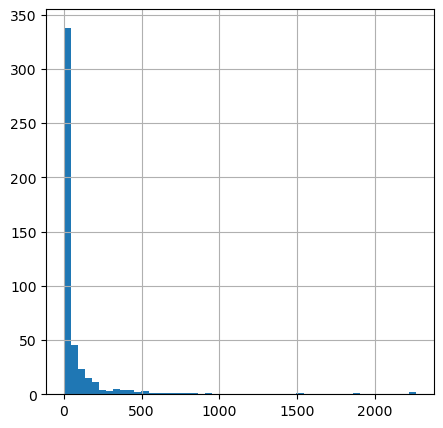

In [48]:
# Obtenemos los estadísticos descriptivos de la columna 'Casos_distrital_2021'
descriptivos = df_2021['Casos_distrital_2021'].describe()
mediana = df_2021['Casos_distrital_2021'].median()

print(f"Estadísticos descriptivos:\n{descriptivos}\n", f"Mediana: {mediana}", '\n', '\n')

# Generamos un gráfico para visualizar mejor la distribución de los datos
fig, ax = plt.subplots(figsize=(5, 5))
df_2021["Casos_distrital_2021"].hist(bins = 50)

# Figura 1

<Axes: title={'center': 'Dengue en el Perú a nivel distrital (2021)'}>

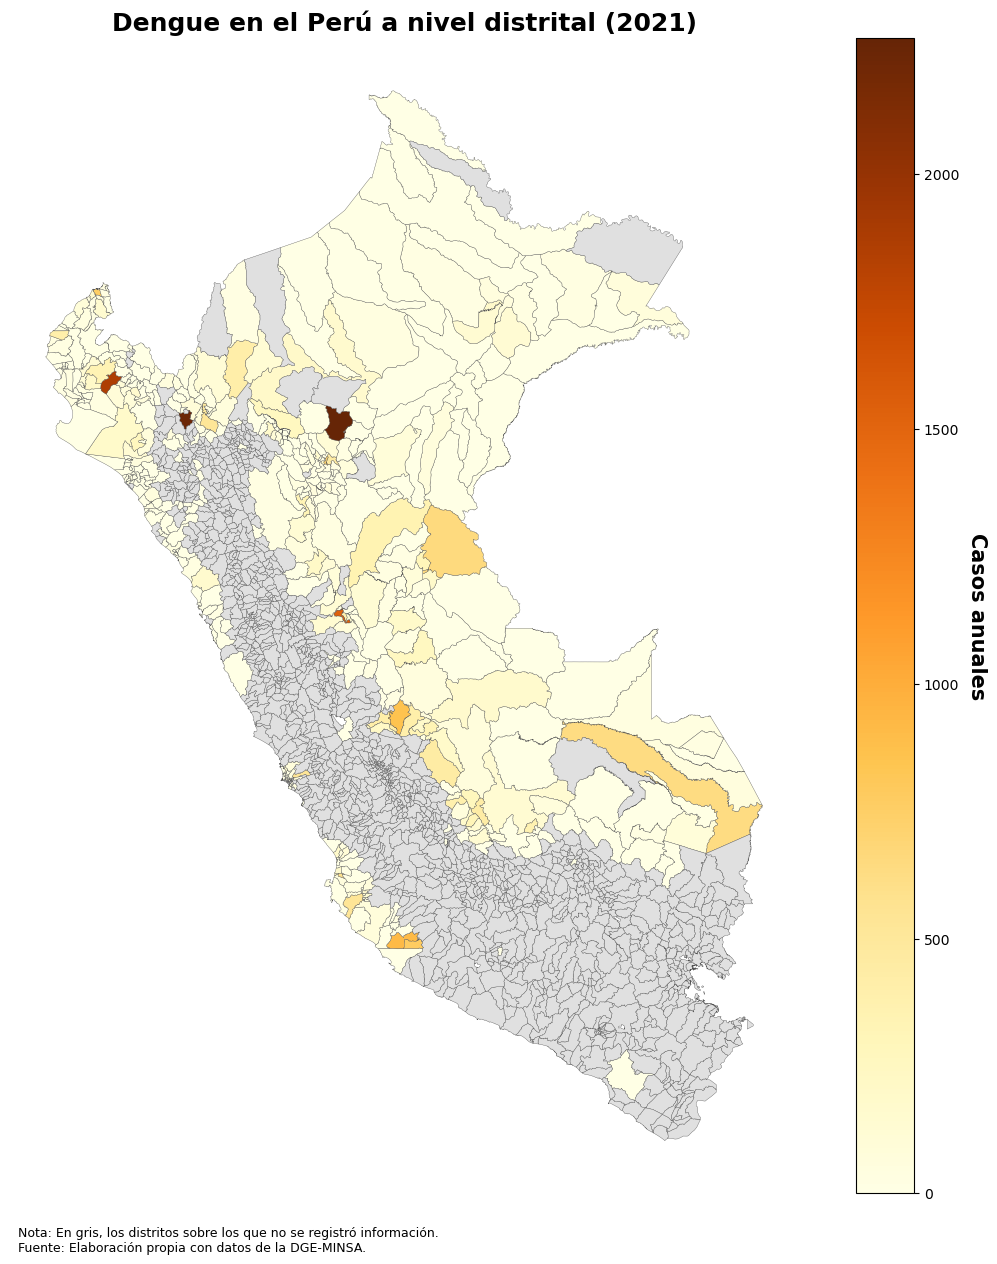

In [289]:
# Graficamos el mapa especificando un color para los valores NaN (con un tono de gris más claro)
F1 = df_2021.plot(column='Casos_distrital_2021',
                  cmap='YlOrBr', 
                  linewidth= 0.25,
                  edgecolor='#515151',
                  missing_kwds={"color": "#e0e0e0",  # Gris más claro que lightgray
                                #"hatch": "/",       # Cambiamos el hatch a líneas paralelas horizontales
                                "label": "No data"},
                  legend=True,
                  figsize=(15, 15))

# Desactivamos los marcadores del eje izquierdo y debajo del mapa
plt.gca().set_axis_off()

# Añadir etiqueta a la barra de color
cbar = F1.get_figure().get_axes()[1]  # Accedemos al segundo eje, que es la barra de color
cbar.set_ylabel('Casos anuales', fontsize=15, fontweight='bold', rotation=270, labelpad=20)  # Rotamos el texto a 270 grados

# Añadimos título
plt.title('Dengue en el Perú a nivel distrital (2021)', fontsize=18, fontweight='bold', ha='center')

# Añadir el texto en la parte inferior izquierda
plt.text(x=0.01, y=-0.05,
         s="Nota: En gris, los distritos sobre los que no se registró información.\nFuente: Elaboración propia con datos de la DGE-MINSA.",
         transform=plt.gca().transAxes, fontsize=9, ha='left')

F1

#4. Casos anuales de dengue a nivel provincial

Primero agregaremos las geometrías del shapefile a nivel provincial.

In [142]:
# Aplicar dissolve para agrupar por Ubigeo_Provincia y sumar los valores de Casos_distrital_2021
df_f2 = df_2021.dissolve(by='Ubigeo_Provincia', aggfunc={'Ubigeo_Departamento': 'first',
                                                         'Departamento': 'first',
                                                         'Provincia': 'first',
                                                         'Casos_distrital_2021': lambda row: row.sum(min_count=1)}
                        ).reset_index()

# Renombrar la columna Casos_distrital_2021 a Casos_provincial_2021
df_f2.rename(columns={'Casos_distrital_2021': 'Casos_provincial_2021'}, inplace=True)

# Reordenamos las columnas
df_f2 = df_f2[['Ubigeo_Departamento', 'Ubigeo_Provincia', 'Departamento', 'Provincia', 'Casos_provincial_2021', 'geometry']]

print(f'El n de filas debería ser 196:', df_f2.shape, '\n')
df_f2.head(5)

El n de filas debería ser 196: (196, 6) 



,Ubigeo_Departamento,Ubigeo_Provincia,Departamento,Provincia,Casos_provincial_2021,geometry
0,01,0101,AMAZONAS,CHACHAPOYAS,0.0,"POLYGON ((-77.78428 -6.94651, -77.78553 -6.948..."
1,01,0102,AMAZONAS,BAGUA,676.0,"POLYGON ((-78.32620 -5.56382, -78.32625 -5.565..."
2,01,0103,AMAZONAS,BONGARA,0.0,"POLYGON ((-77.93780 -6.03777, -77.93781 -6.037..."
3,01,0104,AMAZONAS,CONDORCANQUI,435.0,"POLYGON ((-77.58527 -4.47289, -77.58594 -4.475..."
4,01,0105,<NA>,<NA>,NaN,"POLYGON ((-77.93702 -6.69093, -77.93914 -6.693..."


<Axes: >

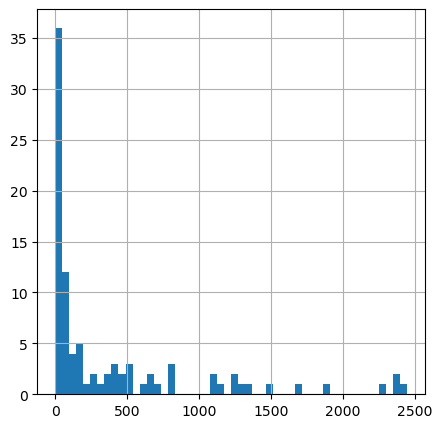

In [144]:
# Verificamos la distribución de los datos
fig, ax = plt.subplots(figsize=(5, 5))
df_f2["Casos_provincial_2021"].hist(bins = 50)

<Axes: title={'center': 'Dengue en el Perú a nivel provincial (2021)'}>

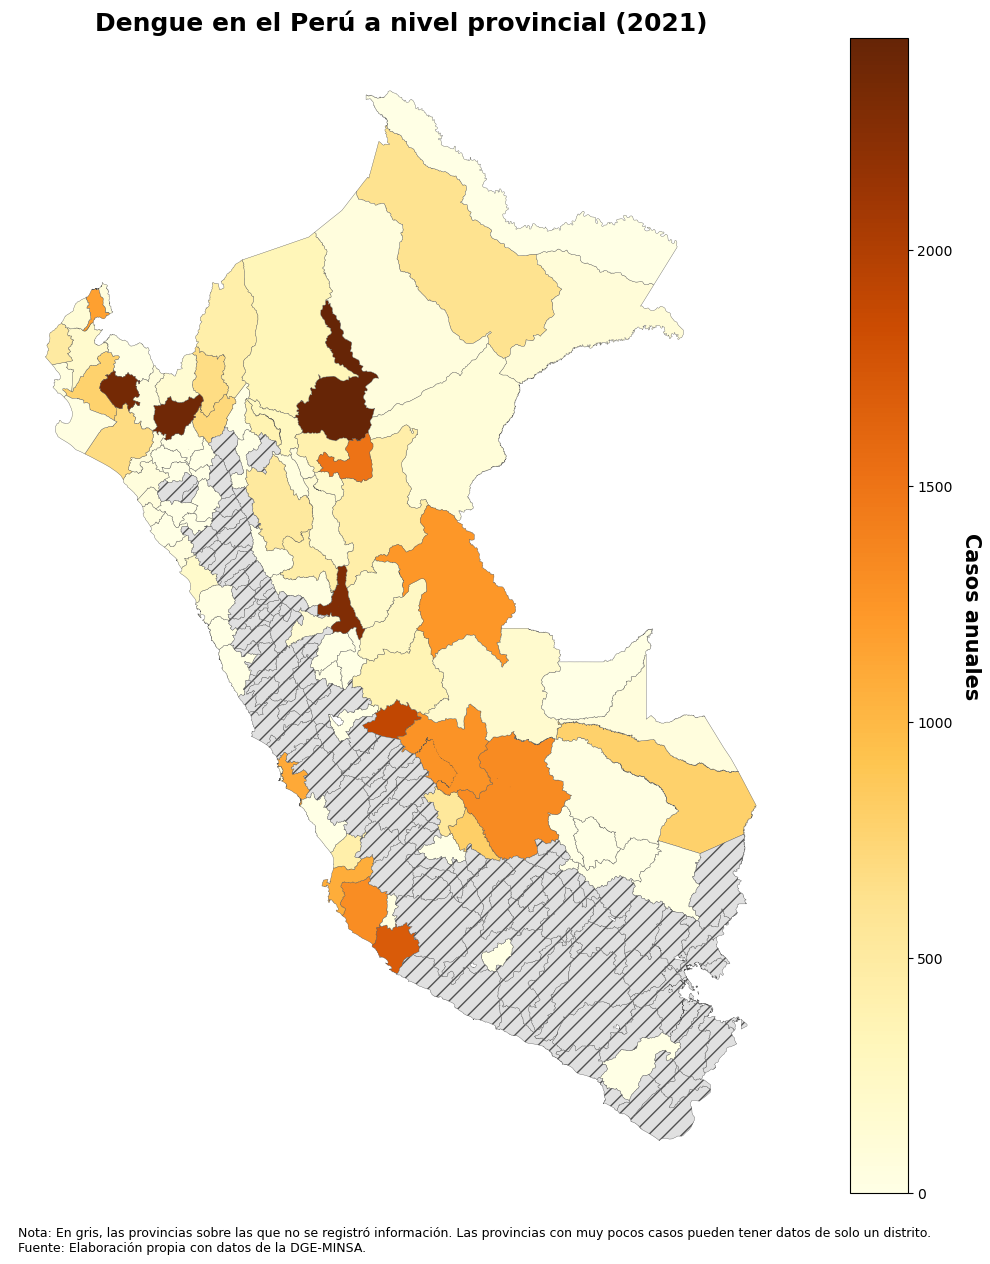

In [287]:
# Graficamos el mapa especificando un color para los valores NaN (con un tono de gris más claro)
F2 = df_f2.plot(column='Casos_provincial_2021',
                cmap='YlOrBr', 
                linewidth= 0.25,
                edgecolor='#515151',
                missing_kwds={"color": "#e0e0e0",
                              "hatch": "//",
                              "label": "No data"},
                legend=True,
                figsize=(15, 15))

# Desactivamos los marcadores del eje izquierdo y debajo del mapa
plt.gca().set_axis_off()

# Ocultar los marcadores de valores pero mantener el recuadro
#plt.gca().tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# Añadir etiqueta a la barra de color
cbar = F2.get_figure().get_axes()[1]  # Accedemos al segundo eje, que es la barra de color
cbar.set_ylabel('Casos anuales', fontsize=15, fontweight='bold', rotation=270, labelpad=20)

# Añadimos título
plt.title('Dengue en el Perú a nivel provincial (2021)', fontsize=18, fontweight='bold', ha='center')

# Añadir el texto en la parte inferior izquierda
plt.text(x=0.01, y=-0.05,
         s="Nota: En gris, las provincias sobre las que no se registró información. Las provincias con muy pocos casos pueden tener datos de solo un distrito.\nFuente: Elaboración propia con datos de la DGE-MINSA.",
         transform=plt.gca().transAxes, fontsize=9, ha='left')

F2

# 5. Casos de dengue en el Perú a nivel departamental (2015-2021)

Primero, preparamos los datos.

In [236]:
# Agrupar por Año y Ubigeo_Departamento, sumando los valores de Casos respetando los NaN
df_dep_años = dengue.groupby(['Año', 'Ubigeo_Departamento', 'Departamento'], as_index=False).agg(
              Casos_departamental_anual=('Casos', lambda row: row.sum(min_count=1)))

print(f'El n de filas debería ser 175 (7 años x 25 departamentos), por la F1 y F2 sabemos que faltan departamentos.\nMás adelante verifiquemos si faltan años.')
print(f'Dimensiones del df:', df_dep_años.shape)
print('\n')
print(df_dep_años.dtypes)
print('\n')
df_dep_años

El n de filas debería ser 175 (7 años x 25 departamentos), por la F1 y F2 sabemos que faltan departamentos.
Más adelante verifiquemos si faltan años.
Dimensiones del df: (147, 4)


Año                                   int64
Ubigeo_Departamento                  object
Departamento                 string[python]
Casos_departamental_anual             Int64
dtype: object




,Año,Ubigeo_Departamento,Departamento,Casos_departamental_anual
0,2015,01,AMAZONAS,37
1,2015,02,ANCASH,118
2,2015,05,AYACUCHO,268
3,2015,06,CAJAMARCA,218
4,2015,07,CALLAO,0
...,...,...,...,...
142,2021,20,PIURA,4010
143,2021,21,PUNO,0
144,2021,22,SAN MARTIN,3966
145,2021,24,TUMBES,1364


In [238]:
# Convertimos las columnas a los tipos adecuados
df_dep_años['Año'] = df_dep_años['Año'].astype('Int64').astype('string')

Completamos las filas que faltan en df_dep_años para que sean 175 en total (7 años x 25 departamentos).

In [244]:
import pandas as pd

# Lista de años como strings
años = [str(a) for a in range(2015, 2022)]  # del 2015 al 2021

# Lista de Ubigeo_Departamento como strings
ubigeo_deps = [f'{i:02d}' for i in range(1, 26)]  # del '01' al '25'

# Bucle para buscar combinaciones faltantes y agregar filas al DataFrame
for año in años:
    for ubigeo_dep in ubigeo_deps:
        # Verificar si la combinación existe
        fila = df_dep_años[(df_dep_años['Año'] == año) & (df_dep_años['Ubigeo_Departamento'] == ubigeo_dep)]
        
        # Si la combinación no existe, agregar una fila con Año y Ubigeo_Departamento (las demás columnas se llenan automáticamente con NaN)
        if fila.empty:
            nueva_fila = pd.DataFrame({'Año': [año], 'Ubigeo_Departamento': [ubigeo_dep]})
            
            # Concatenar la nueva fila al DataFrame original
            df_dep_años = pd.concat([df_dep_años, nueva_fila], ignore_index=True)

# Ordenar el DataFrame por Año y Ubigeo_Departamento
df_dep_años = df_dep_años.sort_values(by=['Año', 'Ubigeo_Departamento'])

# Resetear el índice para reorganizar los números de las filas
df_dep_años.reset_index(drop=True, inplace=True)

# Ver el resultado
df_dep_años

,Año,Ubigeo_Departamento,Departamento,Casos_departamental_anual
0,2015,01,AMAZONAS,37
1,2015,02,ANCASH,118
2,2015,03,<NA>,<NA>
3,2015,04,<NA>,<NA>
4,2015,05,AYACUCHO,268
...,...,...,...,...
170,2021,21,PUNO,0
171,2021,22,SAN MARTIN,3966
172,2021,23,<NA>,<NA>
173,2021,24,TUMBES,1364


In [246]:
# Agrupamos las geometrías por departamento usando 'dissolve' para combinar los polígonos de las filas con el mismo valor en 'Ubigeo_Departamento'
# Añadimos 'reset_index()' para que 'Ubigeo_Departamento' vuelva a ser una columna normal en lugar del índice
geo_departamentos = mapas[['Ubigeo_Departamento', 'geometry']].dissolve(by='Ubigeo_Departamento').reset_index()
geo_departamentos

,Ubigeo_Departamento,geometry
0,01,"POLYGON ((-78.03472 -6.74208, -78.03451 -6.741..."
1,02,"POLYGON ((-77.70189 -10.32392, -77.70434 -10.3..."
2,03,"POLYGON ((-73.51174 -14.53852, -73.51368 -14.5..."
3,04,"POLYGON ((-72.72968 -16.64631, -72.73106 -16.6..."
4,05,"POLYGON ((-74.50188 -15.16058, -74.50191 -15.1..."
5,06,"POLYGON ((-79.07326 -7.46865, -79.08528 -7.462..."
6,07,"POLYGON ((-77.10456 -12.06373, -77.10449 -12.0..."
7,08,"POLYGON ((-71.89418 -14.78954, -71.89579 -14.7..."
8,09,"POLYGON ((-75.23983 -14.04591, -75.25853 -14.0..."
9,10,"POLYGON ((-76.80833 -10.39296, -76.81024 -10.3..."


In [248]:
# Hacemos un merge para agregar la columna 'geometry' desde el df 'mapas'
df_dep_años = pd.merge(geo_departamentos, df_dep_años, on='Ubigeo_Departamento', how='left')

# Reordenamos las columnas
df_dep_años = df_dep_años[['Año', 'Ubigeo_Departamento', 'Departamento', 'Casos_departamental_anual', 'geometry']]

print(df_dep_años.dtypes, '\n')
df_dep_años

Año                                  object
Ubigeo_Departamento                  object
Departamento                 string[python]
Casos_departamental_anual             Int64
geometry                           geometry
dtype: object 



,Año,Ubigeo_Departamento,Departamento,Casos_departamental_anual,geometry
0,2015,01,AMAZONAS,37,"POLYGON ((-78.03472 -6.74208, -78.03451 -6.741..."
1,2016,01,AMAZONAS,90,"POLYGON ((-78.03472 -6.74208, -78.03451 -6.741..."
2,2017,01,AMAZONAS,93,"POLYGON ((-78.03472 -6.74208, -78.03451 -6.741..."
3,2018,01,AMAZONAS,109,"POLYGON ((-78.03472 -6.74208, -78.03451 -6.741..."
4,2019,01,AMAZONAS,164,"POLYGON ((-78.03472 -6.74208, -78.03451 -6.741..."
...,...,...,...,...,...
170,2017,25,UCAYALI,779,"POLYGON ((-75.12008 -8.90434, -75.12004 -8.904..."
171,2018,25,UCAYALI,317,"POLYGON ((-75.12008 -8.90434, -75.12004 -8.904..."
172,2019,25,UCAYALI,214,"POLYGON ((-75.12008 -8.90434, -75.12004 -8.904..."
173,2020,25,UCAYALI,10934,"POLYGON ((-75.12008 -8.90434, -75.12004 -8.904..."


In [250]:
# Convertimos las columnas a los tipos adecuados
df_dep_años['Año'] = df_dep_años['Año'].astype('string')
df_dep_años['Ubigeo_Departamento'] = df_dep_años['Ubigeo_Departamento'].astype('string')
df_dep_años['Casos_departamental_anual'] = df_dep_años['Casos_departamental_anual'].astype(float)
df_dep_años.dtypes

Año                          string[python]
Ubigeo_Departamento          string[python]
Departamento                 string[python]
Casos_departamental_anual           float64
geometry                           geometry
dtype: object

In [259]:
# Ordenar el DataFrame por Año y Ubigeo_Departamento
df_dep_años = df_dep_años.sort_values(by=['Año', 'Ubigeo_Departamento'])
# Resetear el índice para reorganizar los números de las filas
df_dep_años.reset_index(drop=True, inplace=True)
df_dep_años.head(55)

,Año,Ubigeo_Departamento,Departamento,Casos_departamental_anual,geometry
0,2015,01,AMAZONAS,37.0,"POLYGON ((-78.03472 -6.74208, -78.03451 -6.741..."
1,2015,02,ANCASH,118.0,"POLYGON ((-77.70189 -10.32392, -77.70434 -10.3..."
2,2015,03,<NA>,NaN,"POLYGON ((-73.51174 -14.53852, -73.51368 -14.5..."
3,2015,04,<NA>,NaN,"POLYGON ((-72.72968 -16.64631, -72.73106 -16.6..."
4,2015,05,AYACUCHO,268.0,"POLYGON ((-74.50188 -15.16058, -74.50191 -15.1..."
5,2015,06,CAJAMARCA,218.0,"POLYGON ((-79.07326 -7.46865, -79.08528 -7.462..."
6,2015,07,CALLAO,0.0,"POLYGON ((-77.10456 -12.06373, -77.10449 -12.0..."
7,2015,08,CUSCO,248.0,"POLYGON ((-71.89418 -14.78954, -71.89579 -14.7..."
8,2015,09,<NA>,NaN,"POLYGON ((-75.23983 -14.04591, -75.25853 -14.0..."
9,2015,10,HUANUCO,307.0,"POLYGON ((-76.80833 -10.39296, -76.81024 -10.3..."


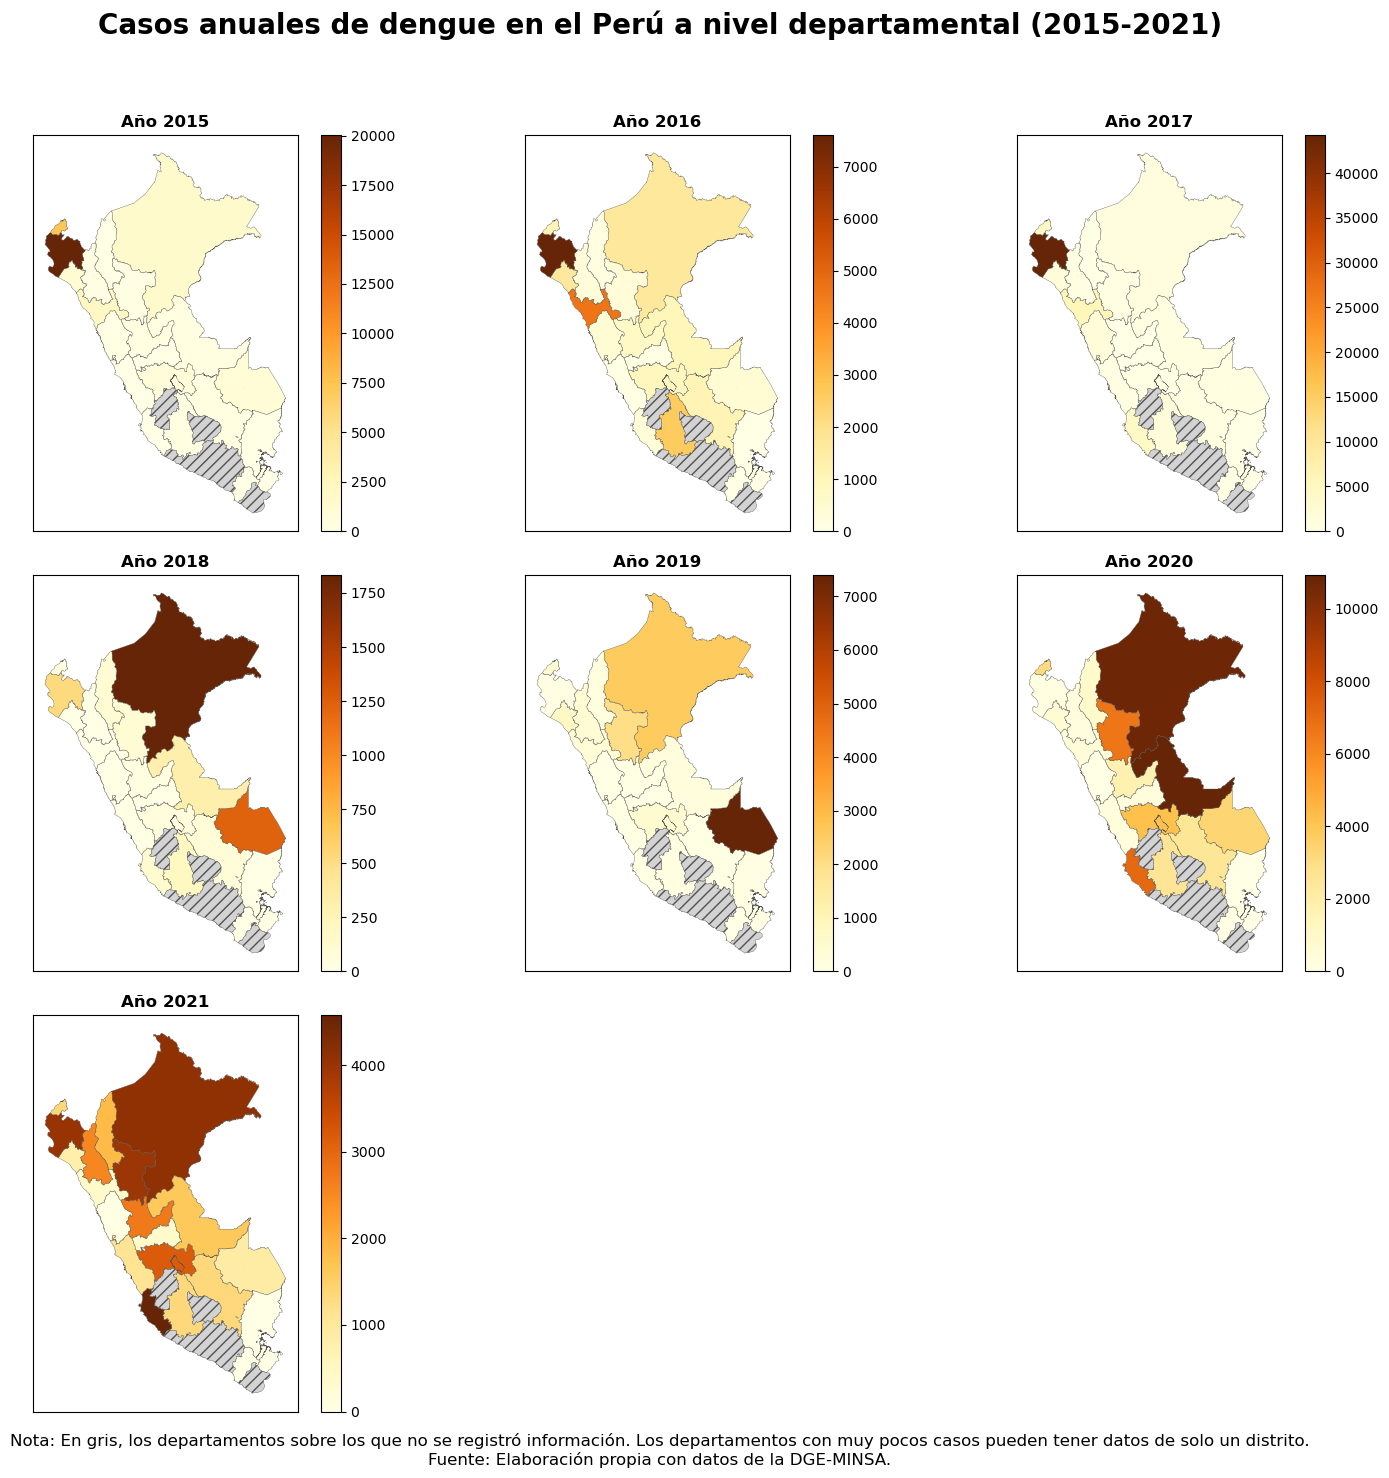

In [291]:
# Crear la figura y los subplots
fig, axis = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Lista de años en tu DataFrame
years = df_dep_años['Año'].unique()

# Variable para controlar la iteración en los subplots
idx = 0

# Iterar sobre las filas y columnas de la matriz de subplots
for i in range(3):
    for j in range(3):
        if idx >= len(years):
            axis[i, j].set_axis_off()  # Desactivar ejes vacíos si no hay más años
            continue
        
        ax = axis[i][j]
        
        # Filtrar los datos del año correspondiente
        year = years[idx]
        df_year = df_dep_años[df_dep_años['Año'] == year]
        
        # Plotear los datos del año en la subplot correspondiente
        F3 = df_year.plot(column='Casos_departamental_anual',
                          cmap='YlOrBr',  # Mapa de color
                          edgecolor='#515151',  # Color del borde
                          linewidth= 0.25,
                          legend=True, 
                          missing_kwds={"color": "lightgray",
                                        "hatch": "///",
                                        "label": "No data"},  # Color para valores NA
                          ax=ax)
        
        # Eliminar los marcadores de los ejes
        ax.set_xticks([])  # Eliminar valores en el eje x
        ax.set_yticks([])  # Eliminar valores en el eje y
        
        # Establecer el título del subplot como el año
        ax.set_title(f'Año {year}', fontsize=12, fontweight='bold')
        
        # Incrementar el índice para pasar al siguiente año
        idx += 1

# Título general centrado
fig.suptitle('Casos anuales de dengue en el Perú a nivel departamental (2015-2021)', fontsize=20, fontweight='bold')

# Texto en la parte inferior centrado
fig.text(0.5, 0.01, 
         "Nota: En gris, los departamentos sobre los que no se registró información. Los departamentos con muy pocos casos pueden tener datos de solo un distrito.\nFuente: Elaboración propia con datos de la DGE-MINSA.", 
         ha='center', fontsize=12)

# Ajustar el espacio entre subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

#6. Casos de dengue a nivel departamental en cada trimestre del 2021